In [1]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib
import random

from math import pi
import scipy

In [2]:
!cp /home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/analysis/results/immune_escape/hmf_reports_background_genes.tsv.gz ../results/data/

In [3]:
pd.options.display.max_columns=200
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
path_escape="../results/data/hmf_reports_background_genes.tsv.gz" # change this with your path


In [4]:
!ls -all ../metadata/dataset_metadata_supp_table3.tsv

-rw-rw-r-- 1 fran fran 2318908 sep 20 13:32 ../metadata/dataset_metadata_supp_table3.tsv


In [5]:
def prepare_metadata():
    df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t")
    df_meta=df_meta[(df_meta["is_selected"]==True)]
    return df_meta[df_meta["cohort"]=="Hartwig"]


# Important: 

The file with the processed mutation and CNV rate of 100 randomly selected genes was generated as : 

- <../results/data/hmf_reports_background_genes.tsv> has been generated using the script scripts/process_data/random_genes/pipeline_extract_genomic_info_backgronund_genes.py across all Hartwig samples. 

- This script runs for each sample in Hartwig the script <scripts/process_data/random_genes/extract_data_random_genes.py> to process the somatic events per sample in these genes



In [6]:
df = pd.read_csv(f"{path_escape}",sep="\t").rename(columns={"sample":"sample_id"})
df_metadata = prepare_metadata()
df=df.merge(df_metadata)
summary_cohort = pd.read_csv("../metadata/table_cancer_types_info.tsv",sep="\t")

In [7]:
df.shape

(4439, 455)

In [8]:
genes_selected=list(pd.read_csv("../results/data/background_genes.tsv",sep="\t")["gene"].values)

### Define alterations to be considered

In [10]:
alterations = pd.read_csv("../metadata/immune_selected_genes.tsv",sep="\t")
alterations=alterations[alterations["Selected"]]

In [11]:
allowed_csq = set(["frameshift_variant","stop_gained","stop_lost","splice_acceptor_variant","splice_donor_variant","stop_gained","splice_region_variant","start_lost"]) # monoallelic
allowed_csq_biallelic = set(["missense_variant","structural_interaction_variant","conservative_inframe_deletion","conservative_inframe_insertion","disruptive_inframe_deletion","disruptive_inframe_insertion"]) # only biallelic 

def non_synonymous(data,genes):
    l=[]
    for entry in data:
        found=False
        if ";" in str(entry):
            for mut in entry.split("__"):
                d=mut.split(";")
                if d[0] in genes and (d[1] in allowed_csq or d[1] in allowed_csq_biallelic):
                    found=True
                    break

        l.append(found)
    return l

def is_loh(df,gene):
    #columns= ["loh_"+g for g in genes]
    return df["loh_"+gene]>0 # Only considering one gene, because of high proximity of HLA-I genes
    
def is_loh_focal(df,gene):

    return (df["loh_"+gene]>0)&(df["loh_focal"].str.contains(gene)) # Only considering one gene, because of high proximity of HLA-I genes

def is_loh_nonfocal(df,gene):
    return (df["loh_"+gene]>0)&(df["loh_nonfocal"].str.contains(gene)) # Only considering one gene, because of high proximity of HLA-I genes

def is_loh_hfocal(df,gene):
    return (df["loh_"+gene]>0)&(df["loh_hfocal"].str.contains(gene)) # Only considering one gene, because of high proximity of HLA-I genes

def is_deepdel(df,genes):
    columns= ["del_"+g for g in genes]
    return df[columns].sum(axis=1)>0 

def get_cn_neutral(df,gene):
    
    l=[]
    v=df[f"ploidy_minor_major_{gene}"].values
    loh=list(df[f"loh_{gene}"].values)
    for k,value in enumerate(v):
        mi,major=value.split(",")
        if int(major) > 1:
            l.append(True and loh[k]==True)
        else:
            l.append(False and loh[k]==True)
    return l

def is_amp(df,genes):
    columns= ["amp_"+g for g in genes]
    return df[columns].sum(axis=1)>0 
    
def clonal_truncating(data,genes):
    l=[]
    for entry in data:
        found=False
        if ";" in str(entry):
            for gene in genes:
                muts_gene=0
                for mut in entry.split("__"):
                    gene_mut,csq,allelic_status,clonality_purple,af,cn,macn=mut.split(";")
                    if gene == gene_mut and (clonality_purple.startswith("clonal"))  and (len(set(csq.split("&")).intersection(allowed_csq))) >0: 
                        found=True
                        break # At least one clonal deleterios mutations
                    if gene == gene_mut and (clonality_purple.startswith("clonal")) and allelic_status == "biallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0 :
                        found=True
                        break # At least one biallelic deleterios or non-synonymous likely impactful mutation (missense)
                    if gene == gene_mut and (clonality_purple.startswith("clonal")) and allelic_status == "monoallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0:
                        muts_gene+=1 # multiple non-synonymous monoallelic mutations
                found=found or muts_gene>1
                if found:# stop iterating, we already have a truncating mutation!
                    break 
        l.append(found)
    return l

def evaluate_type_muts(df,category,genes,is_hla):
    if category == "Non-synonymous, LOH, deep deletion":
        muts_genes=non_synonymous(df["muts_genes"].values,genes)
        loh=is_loh(df,genes[0])# for LOH and deepdel, we evaluate only one gene due to high proximity 
        loh_focal=is_loh_focal(df,genes[0])
        loh_nonfocal=is_loh_nonfocal(df,genes[0])
        loh_hfocal=is_loh_hfocal(df,genes[0])
        loh_is_copy_number_neutral= get_cn_neutral(df,genes[0])
        deep_dels=is_deepdel(df,[genes[0]])# for LOH and deepdel, we evaluate only one gene due to high proximity 
        return ([muts_genes,loh,deep_dels,loh_focal,loh_nonfocal,loh_hfocal,loh_is_copy_number_neutral],["_mut","_loh","_deepdel","_loh_focal","_loh_nonfocal","_loh_hfocal","_loh_cn_neutral"])
    elif category == "Truncating, deep deletion":
        muts_genes=clonal_truncating(df["muts_genes"].values,genes)
        deep_dels=is_deepdel(df,genes)
        return ([muts_genes,deep_dels],["_mut","_deepdel"])
    elif category == "Amplification":
        amps = is_amp(df,genes)
        return ([amps],["_amp"])
    
        
        
        
    

### Annotate raw alterations in randomized genes

In [12]:
for k,pathway in enumerate(alterations["Pathway_general"].unique()):
    pt=alterations[alterations["Pathway_general"]==pathway]
    is_hla= pt =="HLA-I"
    ngenes=pt.shape[0]
    for i in range(100): # perform 100 random iterations
        random.seed(i+k)
        it_genes = random.sample(genes_selected,ngenes)
        for type_mut in list(pt["Type mutations"].unique()):
            values,names=evaluate_type_muts(df,type_mut,it_genes,is_hla) # for LOH and CNV, we evaluate only one gene due to high proximity 
            for j,n in enumerate(names):
                df[f"{pathway.replace(' ','')}{n}_{i}"] = values[j]

### Group them by "pathway"

In [13]:
for i in range(100):
    df["targeted_escape_"+str(i)] = df[f"HLA-I_deepdel_{i}"] | df[f"HLA-I_loh_{i}"] | df[f"HLA-I_mut_{i}"]
    df["systemic_app_pathway_"+str(i)] = df[f"AntigenPresentationPathway_deepdel_{i}"] | df[f"AntigenPresentationPathway_mut_{i}"]
    df["cd58_pathway_"+str(i)] = df[f"CD58immunereceptor_deepdel_{i}"] | df[f"CD58immunereceptor_mut_{i}"]
    df["ifn_gamma_pathway_"+str(i)] = df[f"IFN-gammapathway_deepdel_{i}"] | df[f"IFN-gammapathway_mut_{i}"]
    df["checkpoint_pathway_"+str(i)] = df[f"Immunecheckpointinhibition_amp_{i}"] 
    df["epigenetic_regulators_pathway_"+str(i)] = df[f"Epigeneticimmuneregulation_amp_{i}"] 
    df["non_targeted_escape_"+str(i)] = df["systemic_app_pathway_"+str(i)] | df["ifn_gamma_pathway_"+str(i)] | df["checkpoint_pathway_"+str(i)] | df["cd58_pathway_"+str(i)] | df["epigenetic_regulators_pathway_"+str(i)]
    df["genetic_immune_escape_"+str(i)] = df["targeted_escape_"+str(i)] | df["non_targeted_escape_"+str(i)]
    
    

In [14]:
df.to_csv("../results/data/hmf_randomized_genes_background_processed.tsv.gz",sep="\t",index=False,compression="gzip")

### Compare frequencies observed and expected, pan-cancer across pathways

In [15]:
df_real = pd.read_csv("../results/data/processed_hmf_escape_info.tsv.gz",sep="\t")

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
def get_freq_randomized(df,column):
    ls=[]
    for i in range(100):
        ls.append(df[f"{column}_{i}"].sum() / df.shape[0])
    #x=pd.DataFrame(ls,columns=["gi"])
    return np.nanmean(ls),np.nanmedian(ls),np.nanstd(ls),np.nanpercentile(ls,10),np.nanpercentile(ls,90)


### Per cancer comparison

In [17]:
columns_t={"loh_lilac":"HLA-I_loh","loh_focal":"HLA-I_loh_focal","loh_nonfocal":"HLA-I_loh_nonfocal","mut_hla_lilac":"HLA-I_mut","del_HLA-A":"HLA-I_deepdel","loh_hfocal":"HLA-I_loh_hfocal"}
d=[]
x=df_real["cancer_type"].value_counts()>=15
for ttype in x[x].index:
    for column in ["targeted_escape","systemic_app_pathway","cd58_pathway","ifn_gamma_pathway","checkpoint_pathway","epigenetic_regulators_pathway","non_targeted_escape","genetic_immune_escape","loh_lilac","loh_focal","loh_nonfocal","loh_hfocal","mut_hla_lilac","del_HLA-A"]:
        df_real_t=df_real[df_real["cancer_type"]==ttype]
        if column in columns_t:
            column_name=columns_t[column]
        else:
            column_name=column
        mean,median,std,p10,p90=get_freq_randomized(df[df["cancer_type"]==ttype],column_name)
        if column in ["loh_focal","loh_nonfocal","loh_hfocal"]:
            value_observed=df_real_t[df_real_t[column].str.contains("HLA",na=False)].shape[0] / df_real_t.shape[0]
        elif column == "del_HLA-A":
            value_observed=df_real_t[df_real_t[column]==1].shape[0] / df_real_t.shape[0]
        else: # boolean
            value_observed=df_real_t[df_real_t[column]].shape[0] / df_real_t.shape[0]
        d.append([column,ttype,mean,median,std,p10,p90,value_observed])
stats_ttype=pd.DataFrame(d,columns=["column","cancer_type","mean_randomized","median_randomized","std_randomized","percentile_10","percentile_90","observed_value"])
stats_ttype=stats_ttype.merge(df_real[["cancer_type","cancer_type_code"]].drop_duplicates())

### For column, represent the differences

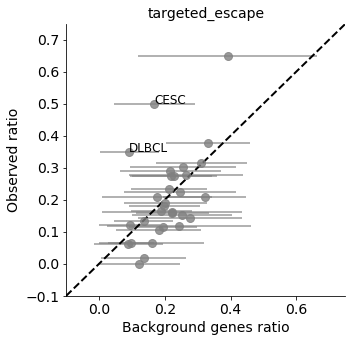

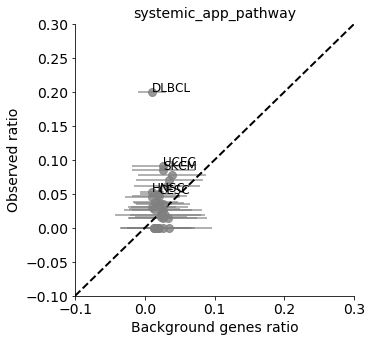

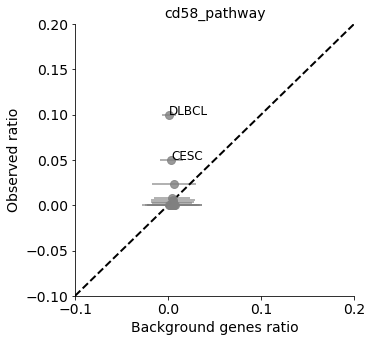

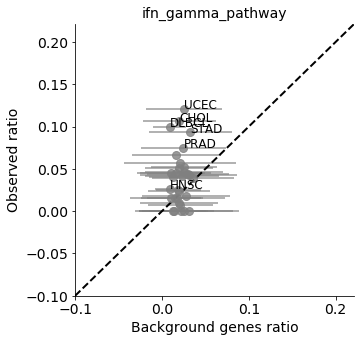

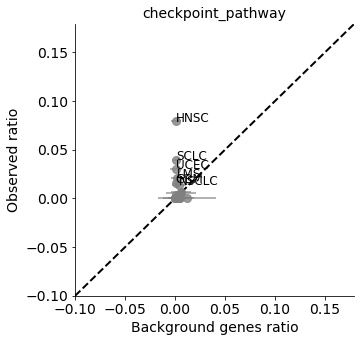

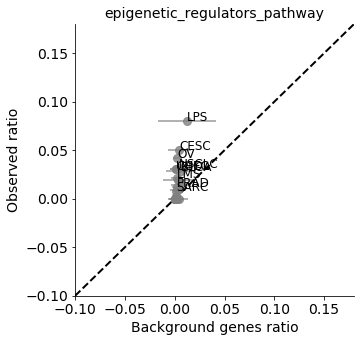

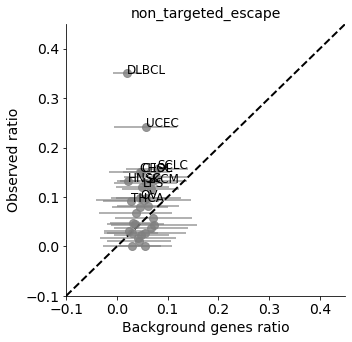

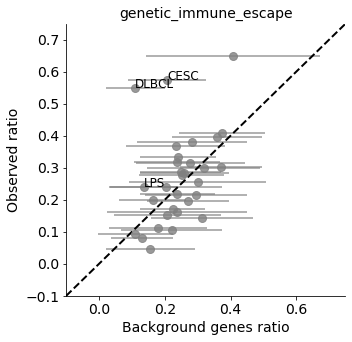

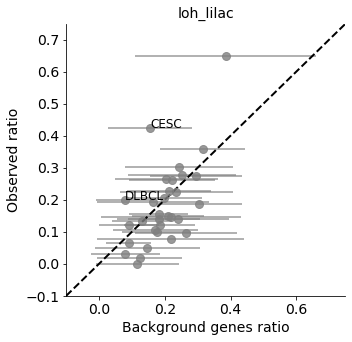

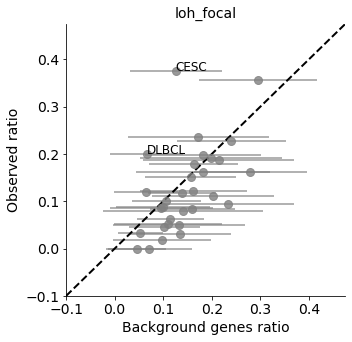

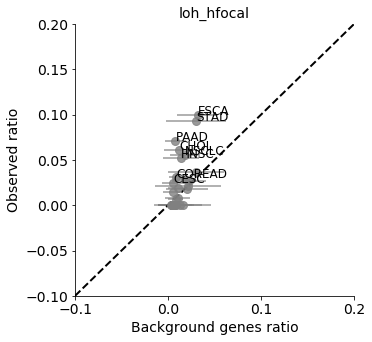

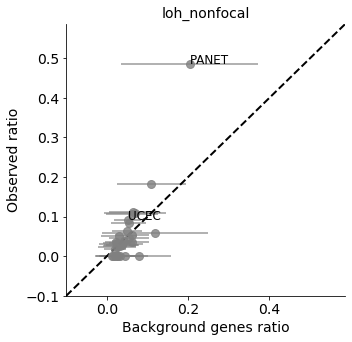

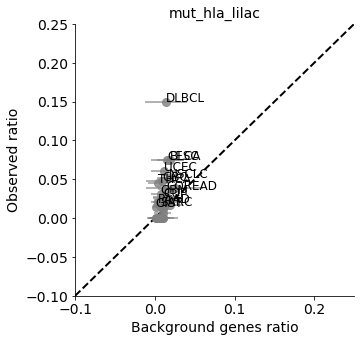

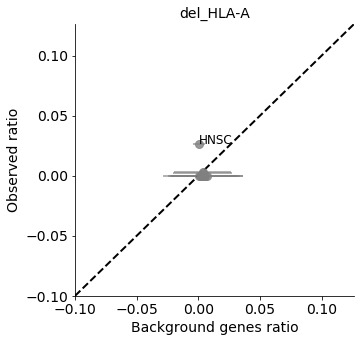

In [18]:
for column in ["targeted_escape","systemic_app_pathway","cd58_pathway","ifn_gamma_pathway","checkpoint_pathway","epigenetic_regulators_pathway","non_targeted_escape","genetic_immune_escape","loh_lilac","loh_focal","loh_hfocal","loh_nonfocal","mut_hla_lilac","del_HLA-A"]:
    fig,ax=plt.subplots(figsize=(5,5))
    s=stats_ttype[stats_ttype["column"]==column]
    s["diff"] = s["observed_value"] - s["mean_randomized"]
    ax.errorbar(y=s["observed_value"],x=s["mean_randomized"],xerr=s["std_randomized"],fmt="o",color="grey",markersize=8,alpha=0.8)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-0.1,np.nanmax([s["observed_value"],s["mean_randomized"]])+0.1)
    ax.set_xlim(-0.1,np.nanmax([s["observed_value"],s["mean_randomized"]])+0.1)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,lw=2,ls="--",color="black")
    ax.set_title(column,fontsize=14)
    for i,r in s[s["observed_value"]>(s["std_randomized"]+s["mean_randomized"])].iterrows():
        ax.annotate(xy=(r["mean_randomized"],r["observed_value"]),s=r["cancer_type_code"],fontsize=12)
    ax.set_ylabel("Observed ratio",fontsize=14)
    ax.set_xlabel("Background genes ratio",fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    
        

### Compute type of LOH (copy-neutral or only one copy for background genes?)

In [19]:
l=[]
for i in range(100):
    for cl in ["HLA-I_loh_nonfocal_","HLA-I_loh_focal_","HLA-I_loh_hfocal_"]:
        column=cl+str(i)
        tmp=df[df[column]==True]
        cn_neutral_freq=tmp[tmp["HLA-I_loh_cn_neutral_"+str(i)]==True].shape[0] / tmp.shape[0]
        l.append([cl,i,cn_neutral_freq])
df_stats_cn = pd.DataFrame(l,columns=["type_loh","iteration","frequency"])
        

In [20]:
df_stats_cn.groupby(["type_loh"],as_index=False).agg(freq_mean=("frequency",np.nanmean),freq_median=("frequency",np.nanmedian))

,type_loh,freq_mean,freq_median
0,HLA-I_loh_focal_,0.738401,0.750755
1,HLA-I_loh_hfocal_,0.705610,0.715633
2,HLA-I_loh_nonfocal_,0.643985,0.660920


In [21]:
l1=[]
for column in ["loh_focal","loh_nonfocal","loh_hfocal"]:
    x=df_real[(df_real["loh_lilac"]==True)&(df_real[column].str.contains("HLA",na=False))]
    v=x[x["copy_number_neutral_loh_hla"].str.contains("HLA",na=False)].shape[0] / x.shape[0]
    base=df_stats_cn[df_stats_cn["type_loh"].str.contains(column)]["frequency"].values
    s=sum(df_stats_cn[df_stats_cn["type_loh"].str.contains(column)]["frequency"].values>=v)
    s1=sum(df_stats_cn[df_stats_cn["type_loh"].str.contains(column)]["frequency"].values<v)
    l1.append([column,v,np.nanmean(base),np.nanmedian(base),np.nanstd(base),s,s/100,s1,s1/100])
df_significance=pd.DataFrame(l1,columns=["column","cn_neutral_observed","mean_expected","median_expected","std_expected","number_randomizations_higher_freq_observed","pvalue_higher","number_randomizations_lower_freq_observed","pvalue_lower"])

In [22]:
df_significance

,column,cn_neutral_observed,mean_expected,median_expected,std_expected,number_randomizations_higher_freq_observed,pvalue_higher,number_randomizations_lower_freq_observed,pvalue_lower
0,loh_focal,0.812808,0.738401,0.750755,0.096932,25,0.25,75,0.75
1,loh_nonfocal,0.655172,0.643985,0.660920,0.119289,52,0.52,48,0.48
2,loh_hfocal,0.804688,0.705610,0.715633,0.105942,18,0.18,82,0.82


### Same analysis by cancer type

In [23]:
l=[]
ct=df_real[df_real["loh_lilac"]==True]["cancer_type_code"].value_counts()>9
for ttype in ct[ct].index:
    for i in range(100):
        for cl in ["HLA-I_loh_nonfocal_","HLA-I_loh_focal_","HLA-I_loh_hfocal_"]:
            column=cl+str(i)
            tmp=df[(df[column]==True)&(df["cancer_type_code"]==ttype)]
            if tmp.shape[0] >0:
                cn_neutral_freq=tmp[tmp["HLA-I_loh_cn_neutral_"+str(i)]==True].shape[0] / tmp.shape[0]
            else:
                cn_neutral_freq=0
            l.append([ttype, cl,i,cn_neutral_freq])
df_stats_cn_ttype = pd.DataFrame(l,columns=["cancer_type_code","type_loh","iteration","frequency"])
        

In [24]:
l1=[]

for ttype in (ct[ct].index):
    query=df_stats_cn_ttype[df_stats_cn_ttype["cancer_type_code"]==ttype]
    for column in ["loh_focal","loh_nonfocal","loh_hfocal"]:
        x=df_real[(df_real["loh_lilac"]==True)&(df_real[column].str.contains("HLA",na=False))&(df_real["cancer_type_code"]==ttype)]
        if x.shape[0] == 0:
            v=0
        else:
            v=x[(x["copy_number_neutral_loh_hla"].str.contains("HLA",na=False))].shape[0] / x.shape[0]
        base=query[query["type_loh"].str.contains(column)]["frequency"].values
        s=sum(query[query["type_loh"].str.contains(column)]["frequency"].values>=v)
        s1=sum(query[query["type_loh"].str.contains(column)]["frequency"].values<v)
        l1.append([ttype,column,v,np.nanmean(base),np.nanmedian(base),np.nanstd(base),s,s/100,s1,s1/100])
df_significance_ttype=pd.DataFrame(l1,columns=["cancer_type_code","column","cn_neutral_observed","mean_expected","median_expected","std_expected","number_randomizations_higher_freq_observed","pvalue_higher","number_randomizations_lower_freq_observed","pvalue_lower"])

In [25]:
df_significance_ttype.sort_values("number_randomizations_higher_freq_observed")

,cancer_type_code,column,cn_neutral_observed,mean_expected,median_expected,std_expected,number_randomizations_higher_freq_observed,pvalue_higher,number_randomizations_lower_freq_observed,pvalue_lower
50,GIST,loh_hfocal,1.000000,0.115000,0.000000,0.272534,6,0.06,94,0.94
41,CESC,loh_hfocal,1.000000,0.110000,0.000000,0.312890,11,0.11,89,0.89
6,BRCA,loh_focal,0.804598,0.689105,0.681818,0.126936,11,0.11,89,0.89
15,SKCM,loh_focal,0.894737,0.654976,0.644958,0.146998,11,0.11,89,0.89
35,PRAD,loh_hfocal,0.857143,0.576680,0.571429,0.244307,15,0.15,85,0.85
20,PAAD,loh_hfocal,0.714286,0.199524,0.000000,0.356341,15,0.15,85,0.85
17,SKCM,loh_hfocal,1.000000,0.436452,0.500000,0.364400,20,0.20,80,0.80
47,LMS,loh_hfocal,1.000000,0.264405,0.000000,0.414495,20,0.20,80,0.80
16,SKCM,loh_nonfocal,0.909091,0.667541,0.666667,0.196986,21,0.21,79,0.79
8,BRCA,loh_hfocal,0.904762,0.719850,0.693980,0.183049,21,0.21,79,0.79


In [26]:
df_real[(df_real["loh_lilac"]==True)&(df_real["cancer_type_code"]==ttype)]

,sample_id,del_HLA-A,del_HLA-B,del_HLA-C,ploidy_minor_HLA-A,ploidy_minor_HLA-B,ploidy_minor_HLA-C,ploidy_major_HLA-A,ploidy_major_HLA-B,ploidy_major_HLA-C,mut_transport_mhc,mut_scaffold_mhc,mut_cd58,mut_interferon,mut_tfs,del_transport_mhc,del_cd58,del_scaffold_mhc,del_interferon,amps_inhibitors,del_tfs,epigenetic_regulators,n_germline_alleles,avg_divergence_germline,sum_diversity_germline,avg_diversity_locus,purity,diploidProportion,wholeGenomeDuplication,msStatus,tmlStatus,tmbPerMb,svTumorMutationalBurden,missense,frameshift,mnvs,QC_LILAC,A1,A2,B1,B2,C1,C2,A1_CN,A2_CN,B1_CN,B2_CN,C1_CN,C2_CN,A1_MUT,A2_MUT,B1_MUT,B2_MUT,C1_MUT,C2_MUT,loh_lilac,mut_hla_lilac,imbalance_lilac,loh_hfocal,loh_focal,loh_nonfocal,imbalance_hfocal,imbalance_focal,imbalance_nonfocal,total_fusions,total_reported_fusions,sample_id_2,index,cohort,patient_id,icgc_aliquot_id,icgc_specimen_id,icgc_sample_id,tissue_type,tissue_group,cancer_type,cancer_type_code,blacklist_comment,biopsy_site,simplified_biopsy_site,tumor_purity,tumor_purity_rank,n_biopsies_in_patient,n_cancer_types_in_patient,is_selected_biopsy,ploidy,gender,whole_genome_duplication,msi_status,hr_status,had_radiotherapy,had_other_treatment,had_chemotherapy,had_hormone_therapy,had_targeted_therapy,had_immunotherapy,treatment_info_available,sv_load,smnv_load,sbs_load,dbs_load,indel_load,sbs_load.clonal,dbs_load.clonal,indel_load.clonal,sbs_load.subclonal,dbs_load.subclonal,indel_load.subclonal,lilac_status,has_lilac,blacklisted_gie,blacklist_gie_comment,is_selected,has_group_cohort,has_group_mut_signatures,has_rna,bcells,cd45,cd8,cytox,dc,exhausted_cd8,macroph,mast_cells,neutrophil,nk_cd56n,nk,tcells,th1,treg,infiltration_davoli,cd4_davoli,cd8_davoli,t_cell_grasso,ifn-gamma,systemic_app_pathway,systemic_app_pathway_detail,cd58_pathway,cd58_pathway_detail,ifn_gamma_pathway,ifn_gamma_pathway_detail,checkpoint_pathway,checkpoint_pathway_detail,epigenetic_regulators_pathway,epigenetic_regulators_pathway_detail,targeted_app_pathway_mut_HLA,targeted_app_pathway_loh_HLA,targeted_app_pathway_del_HLA,targeted_app_pathway_partdel_HLA,targeted_escape,non_targeted_escape,genetic_immune_escape,copy_number_neutral_loh_hla
18,WIDE01010980T,0.0,0.0,0.0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,12.902026,193.530387,9.036832,0.68,0.6409,False,MSS,LOW,1.970619,147,34,4,74,PASS,A*24:02,A*34:02,B*08:01,B*44:02,C*06:02,C*07:01,0.00,1.00,1.00,0.00,0.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,NaN,"HLA-A,HLA-C,HLA-B",NaN,NaN,NaN,NaN,39,0,HMF004984A,4545,Hartwig,HMF004984,NaN,NaN,NaN,HeadAndNeck,Head_and_neck,Upper respiratory tract cancer,HNSC,NaN,NaN,Unknown,0.68,1.0,1.0,1.0,True,1.88,MALE,False,MSS,HR_proficient,NaN,NaN,NaN,NaN,NaN,NaN,False,147.0,5634.0,5052.0,64.0,508.0,3618.0,23.0,311.0,1429.0,40.0,191.0,PASS,True,False,NaN,True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,True,False,True,True,False,True,NaN
392,CPCT02030330T,0.0,0.0,0.0,0,0,0,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,12.372376,185.585635,7.360958,0.50,0.1338,True,MSS,LOW,8.413431,1043,127,6,344,PASS,A*02:01,A*29:02,B*15:01,B*45:01,C*03:03,C*06:02,2.97,0.00,2.97,0.00,2.97,0.00,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,NaN,"HLA-A,HLA-C,HLA-B",NaN,NaN,NaN,NaN,134,0,HMF000557A,4512,Hartwig,HMF000557,NaN,NaN,NaN,HeadAndNeck,Head_and_neck,Upper respiratory tract cancer,HNSC,NaN,Lymph node,Lymph,0.50,1.0,1.0,1.0,True,2.82,MALE,True,MSS,HR_proficient,True,False,True,False,False,False,True,1043.0,24054.0,21920.0,297.0,1790.0,21544.0,289.0,1747.0,353.0,7.0,22.0,PASS,True,False,NaN,True,True,True,True,-3.047247,1.560226,-0.100287,-1.271553,-1.444144,-0.112889,3.769360,2.792121,-1.436663,-2.678888,-1.136087,-0.709681,-2.117787,1.050328,-0.275054,-0.217759,-0.576072,0.354389,0.019696,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,True,False,True,True,False,True,"HLA-A,HLA-C,HLA-B"
1247,WIDE01010017T,0.0,0.0,